# Equatorial Upperocean model vs. obs comparison

The goal of this notebook is the following:

1) serve as an example of how to post-process CESM/MOM6 output;

2) create time averages of T, S and VEL fields and compared agains observations (PHC2 and Johnson et al, 2002);

TODO:
* Compare potential density plots;
* compare model results vs. another model results (TODO);


In [1]:
%matplotlib inline
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import shiftgrid, request_workers
from mom6_tools.m6plot import yzcompare, yzplot
from mom6_tools.DiagsCase import DiagsCase
import yaml
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import display, Markdown, Latex
import warnings
warnings.filterwarnings("ignore")

Basemap module not found. Some regional plots may not function properly


In [2]:
# Read in the yaml file
diag_config_yml_path = "/glade/u/home/gmarques/libs/mom6-tools/docs/source/examples/diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [3]:
# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
print('Casename is:', dcase.casename)

Casename is: g.c2b6.GJRA.TL319_t061.long_JRA_mct.076


In [4]:
# Load the grid
RUNDIR = dcase.get_value('RUNDIR')
grd = MOM6grid(RUNDIR+'/'+dcase.casename+'.mom6.static.nc', xrformat=True)
grd_eq = grd.sel(yh=slice(-10,10)) 

MOM6 grid successfully loaded... 



In [5]:
parallel, cluster, client = request_workers(6)

Requesting 6 workers... 

/proxy/8787/status


In [6]:
client

<Client: 'tcp://10.148.10.19:32847' processes=0 threads=0, memory=0 B>

In [7]:
# Compute the climatology dataset
#dset_climo = climo.stage()
variables = ['thetao', 'so', 'uo', 'time', 'time_bnds', 'e']
RUNDIR = dcase.get_value('RUNDIR')

def preprocess(ds):
    ''' Compute yearly averages and return the dataset with variables'''
    return ds[variables].resample(time="1Y", closed='left', \
           keep_attrs=True).mean(dim='time', keep_attrs=True)

ds = xr.open_mfdataset(RUNDIR+'/'+dcase.casename+'.mom6.h_*.nc', \
         parallel=True, data_vars='minimal', \
         coords='minimal', compat='override', preprocess=preprocess)

In [8]:
# load obs 
catalog = intake.open_catalog("/glade/campaign/cgd/oce/catalogs/reference-datasets.yml")
phc = catalog["PHC2-tx0.66v1"].to_dask().rename({'X': 'xh','Y': 'yh', 'depth': 'z_l'})
thetao_obs = phc.TEMP
salt_obs = phc.SALT
johnson = catalog["eq-uvts-johnson"].to_dask()

In [10]:
# set coordinates to the same as the model's
thetao_obs['xh'] = ds.xh; thetao_obs['yh'] = ds.yh;
salt_obs['xh'] = ds.xh; salt_obs['yh'] = ds.yh;

In [11]:
# select in space and time
avg = diag_config_yml['Avg']
start_date = avg['start_date']
end_date = avg['end_date']
    
%time ds = ds.sel(time=slice(start_date, end_date)).sel(yh=slice(-10,10)).isel(z_i=slice(0,15)).isel(z_l=slice(0,14))

CPU times: user 14.5 ms, sys: 0 ns, total: 14.5 ms
Wall time: 14 ms


In [12]:
print('Time averaging...')
thetao = ds.thetao.mean('time')
so = ds.so.mean('time')
uo = ds.uo.mean('time')
eta = ds.e.mean('time')

Time averaging...


In [13]:
print('Selecting equatorial data...')
# find point closest to eq. and select data
j = np.abs( grd_eq.geolat[:,0].values - 0. ).argmin()
temp_eq = np.ma.masked_invalid(thetao.isel(yh=j).values)
salt_eq = np.ma.masked_invalid(so.isel(yh=j).values)
u_eq    = np.ma.masked_invalid(uo.isel(yh=j).values)
e_eq    = np.ma.masked_invalid(eta.isel(yh=j).values)
thetao_obs_eq = np.ma.masked_invalid(thetao_obs.sel(yh=slice(-10,10)).isel(yh=j).isel(z_l=slice(0,14)).values)
salt_obs_eq = np.ma.masked_invalid(salt_obs.sel(yh=slice(-10,10)).isel(yh=j).isel(z_l=slice(0,14)).values)

Selecting equatorial data...


In [14]:
client.close(); cluster.close()

In [15]:
y = ds.yh.values
zz = ds.z_i.values
x = ds.xh.values
[X, Z] = np.meshgrid(x, zz)
z = 0.5 * ( Z[:-1] + Z[1:])

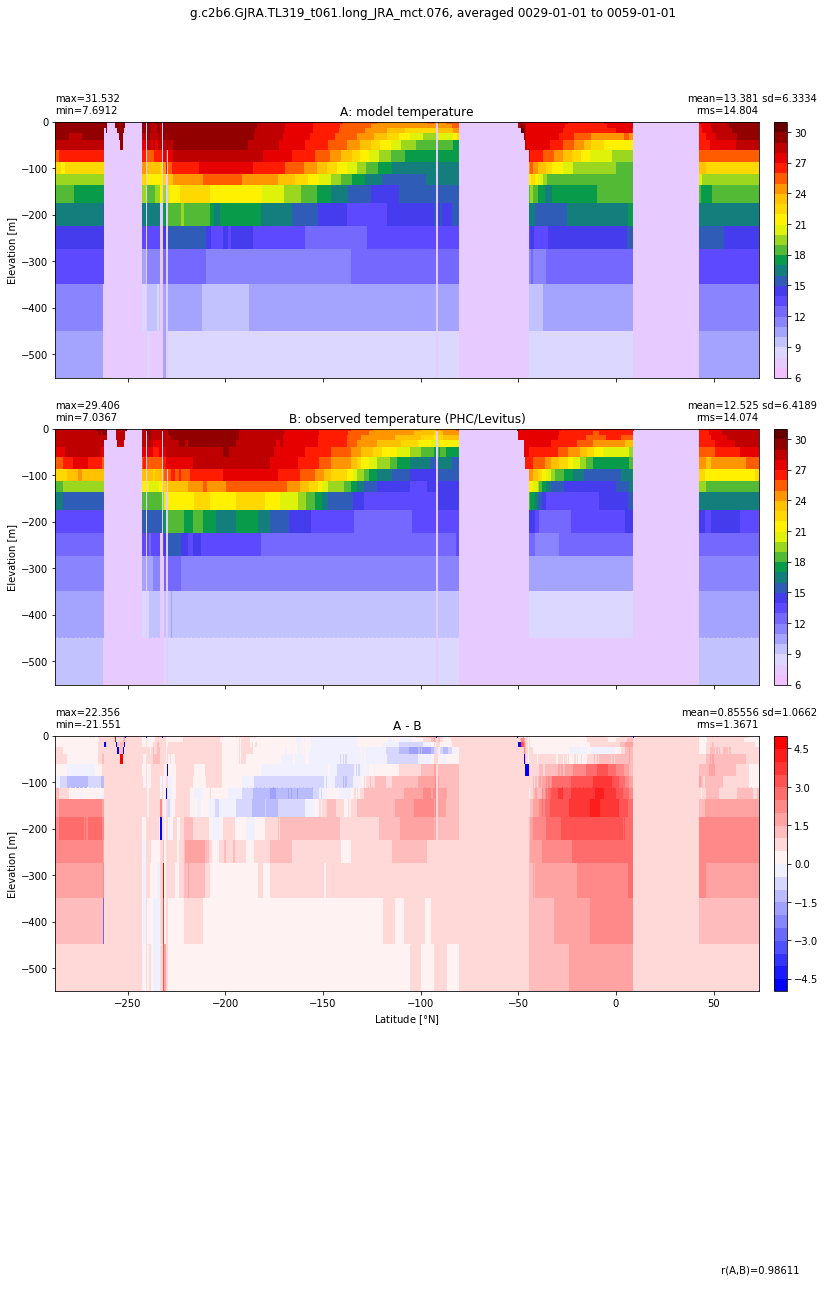

In [16]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,16))
yzcompare(temp_eq , thetao_obs_eq, x, -Z,
        title1 = 'model temperature',
        title2 = 'observed temperature (PHC/Levitus)', axis=ax,
        suptitle=dcase.casename + ', averaged '+str(start_date)+ ' to ' +str(end_date),
        extend='neither', dextend='neither', clim=(6,31.), dlim=(-5,5), dcolormap=plt.cm.bwr)

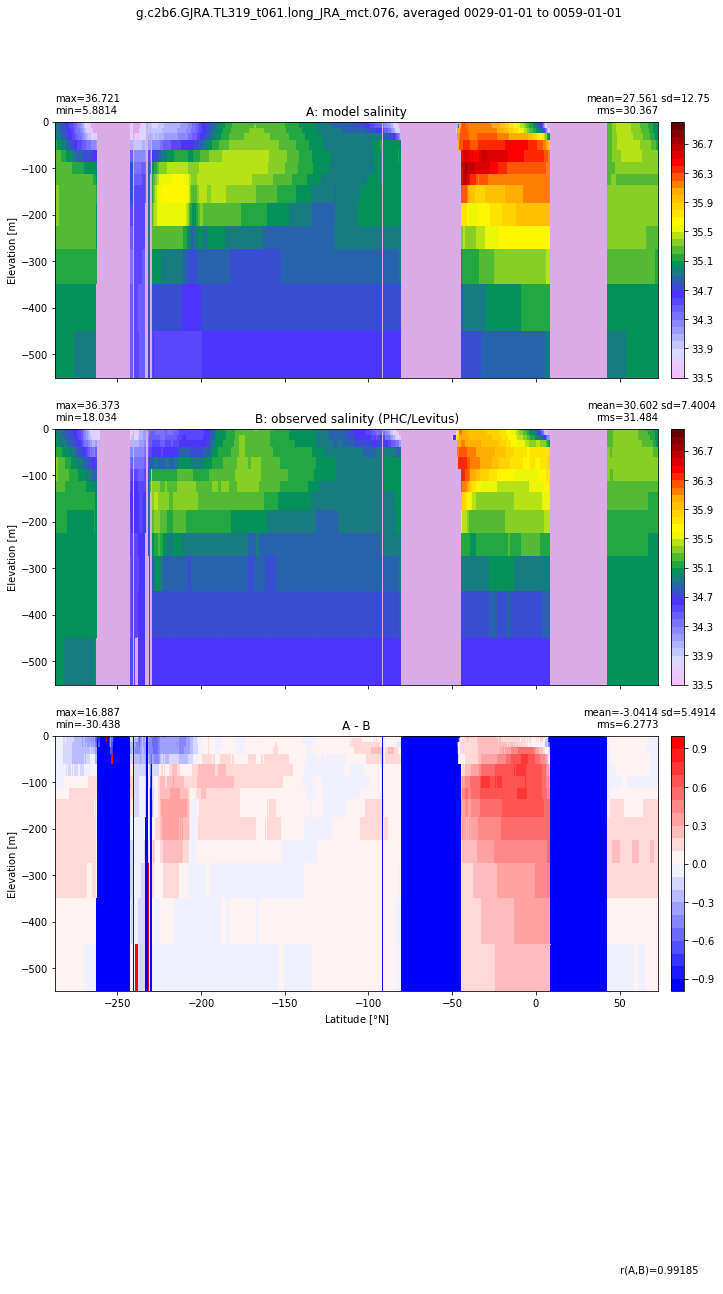

In [17]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,16))
yzcompare(salt_eq , salt_obs_eq, x, -Z,
        title1 = 'model salinity',
        title2 = 'observed salinity (PHC/Levitus)', axis=ax,
        suptitle=dcase.casename + ', averaged '+str(start_date)+ ' to ' +str(end_date),
        extend='neither', dextend='neither', clim=(33.5,37.), dlim=(-1,1), dcolormap=plt.cm.bwr)

(-400, 0)

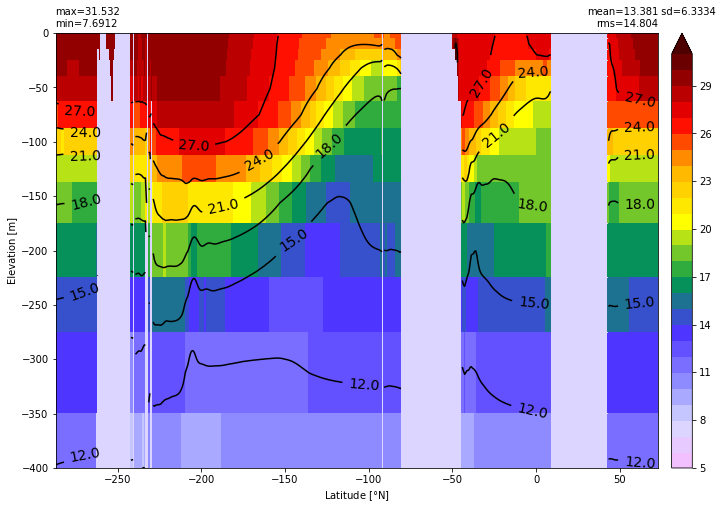

In [18]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
yzplot(temp_eq, x, -Z, axis=ax, clim=(5,31), landcolor=[0., 0., 0.], ignore=np.nan)
cs1 = ax.contour( x + 0*z, -z, temp_eq,  colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
plt.ylim(-400,0)

(-400, 0)

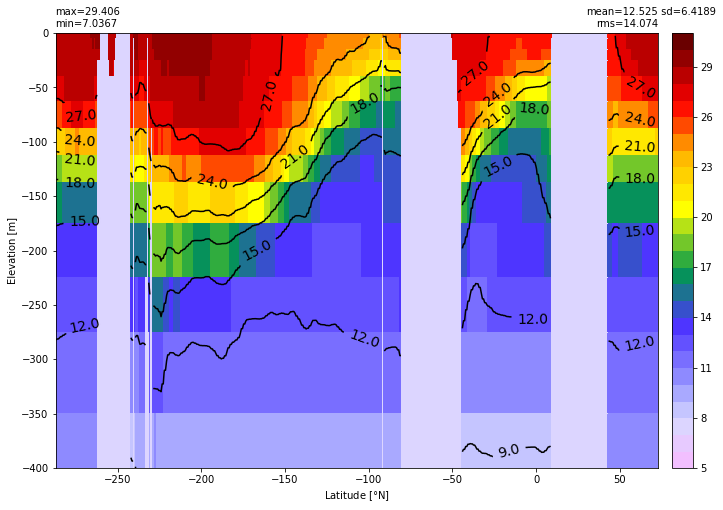

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
yzplot(thetao_obs_eq, x, -Z, axis=ax, clim=(5,31))
cs1 = ax.contour( x + 0*z, -z, thetao_obs_eq,  colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
ax.set_ylim(-400,0)

In [20]:
# Shift model data to compare against obs
tmp, lonh = shiftgrid(thetao.xh[-1].values, thetao[0,0,:].values, ds.thetao.xh.values)
tmp, lonq = shiftgrid(uo.xq[-1].values, uo[0,0,:].values, uo.xq.values)

thetao['xh'].values[:] = lonh
so['xh'].values[:] = lonh
uo['xq'].values[:] = lonq

In [21]:
# y and z from obs 
y_obs = johnson.YLAT11_101.values
zz = np.arange(0,510,10)
[Y, Z_obs] = np.meshgrid(y_obs, zz)
z_obs = 0.5 * ( Z_obs[0:-1,:] + Z_obs[1:,] )

In [22]:
# y and z from model
y_model = thetao.yh.values
z = eta.z_i.values
[Y, Z_model] = np.meshgrid(y_model, z)
z_model = 0.5 * ( Z_model[0:-1,:] + Z_model[1:,:] )

In [23]:
longitudes = [143., 156., 165., 180., 190., 205., 220., 235., 250., 265.]

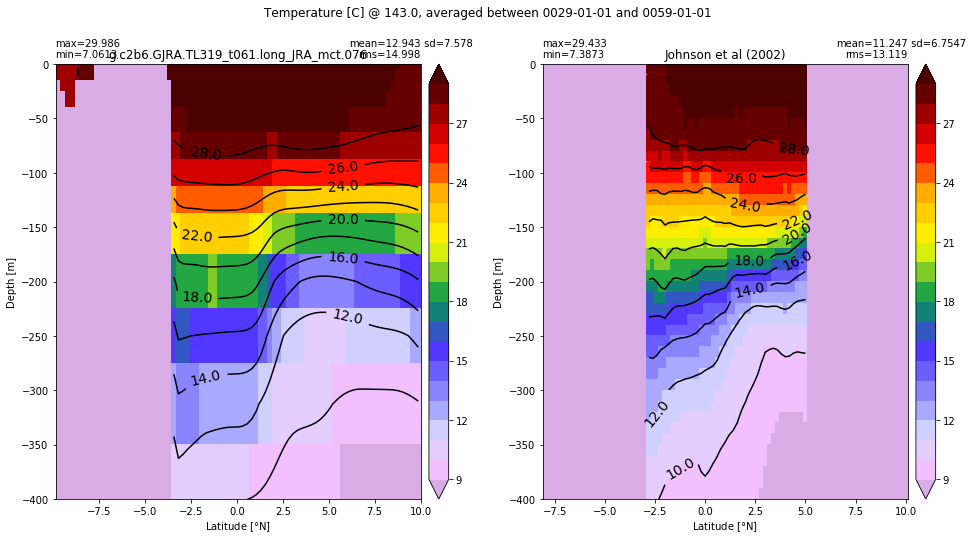

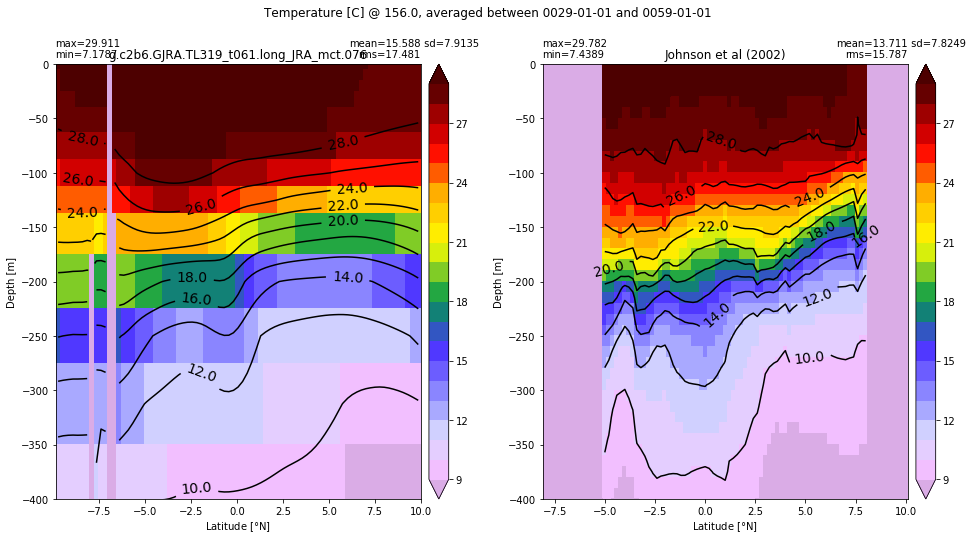

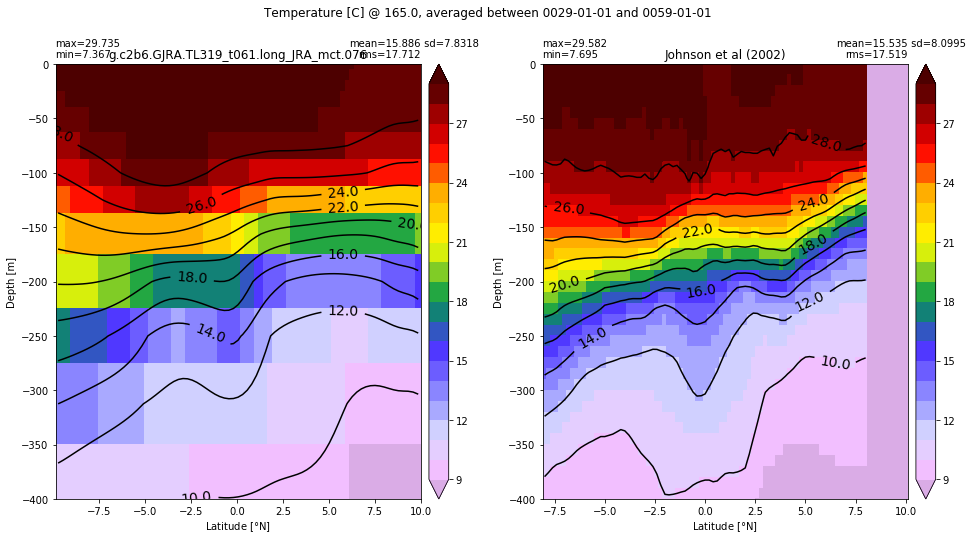

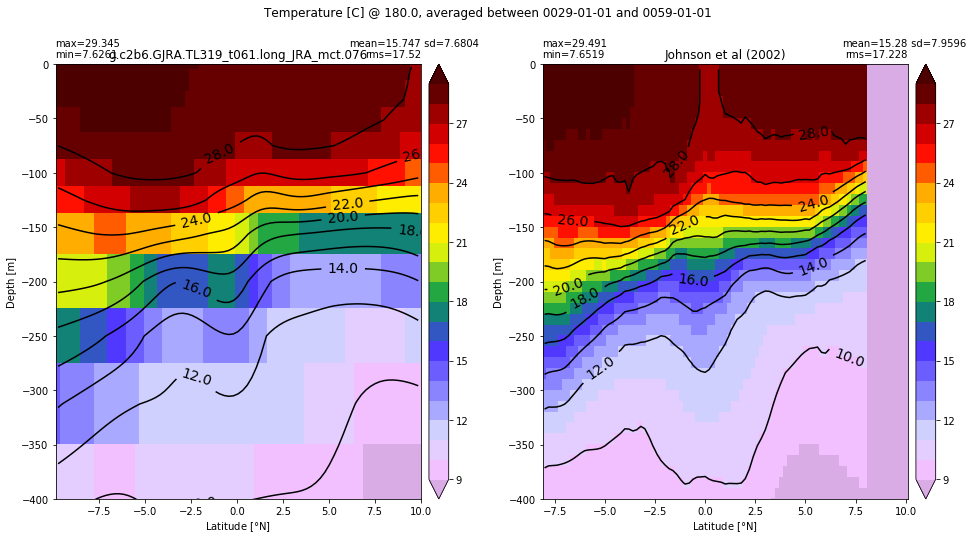

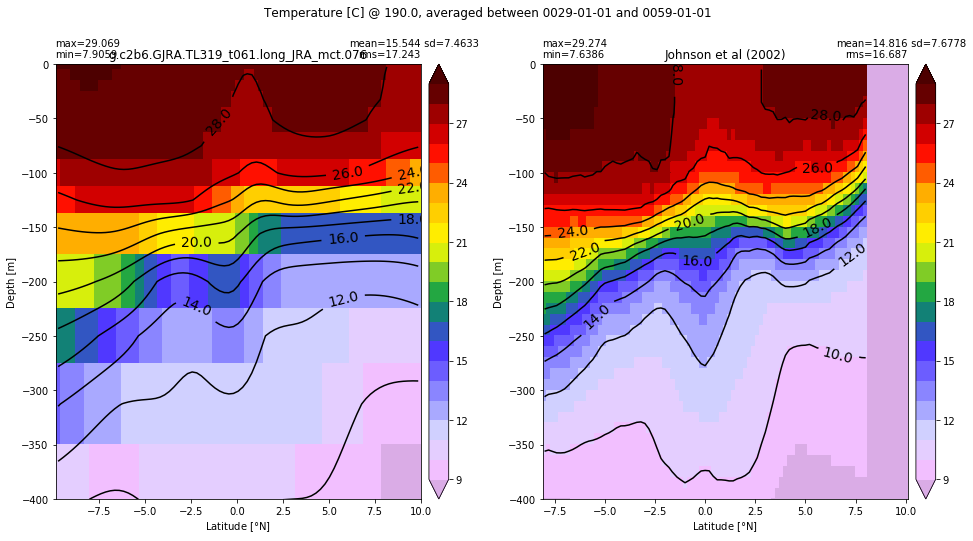

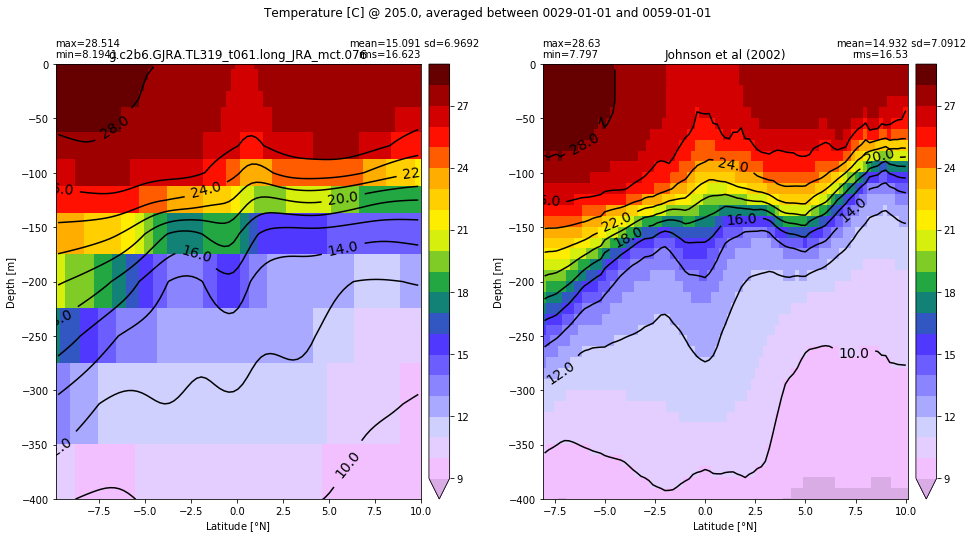

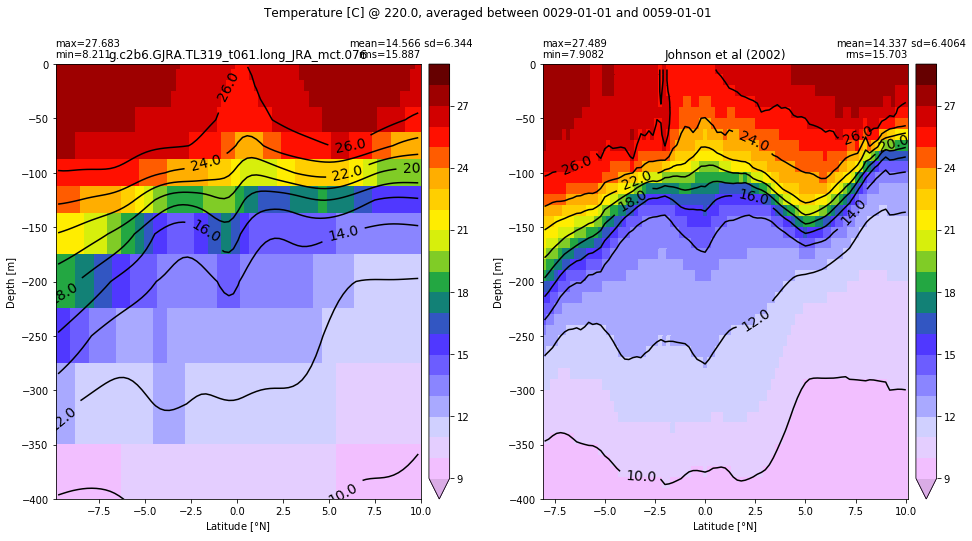

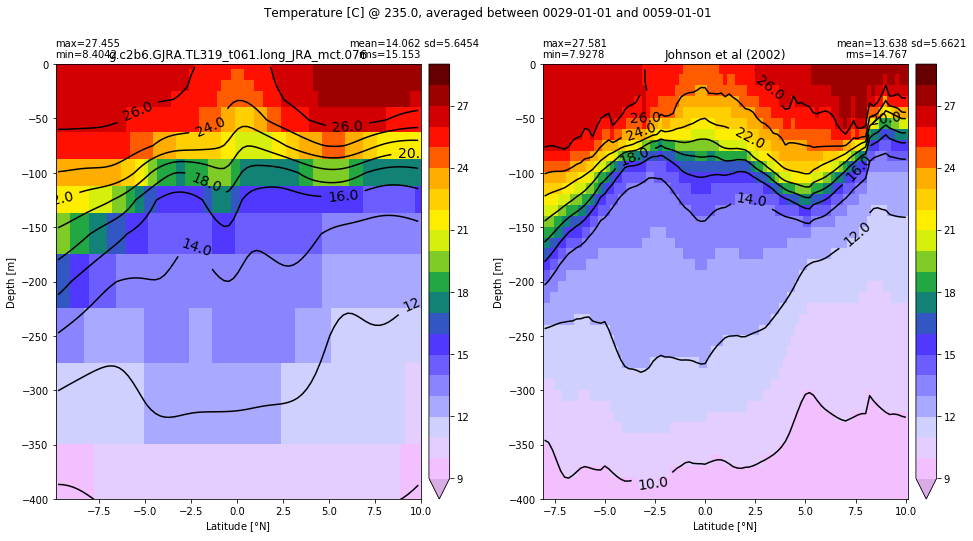

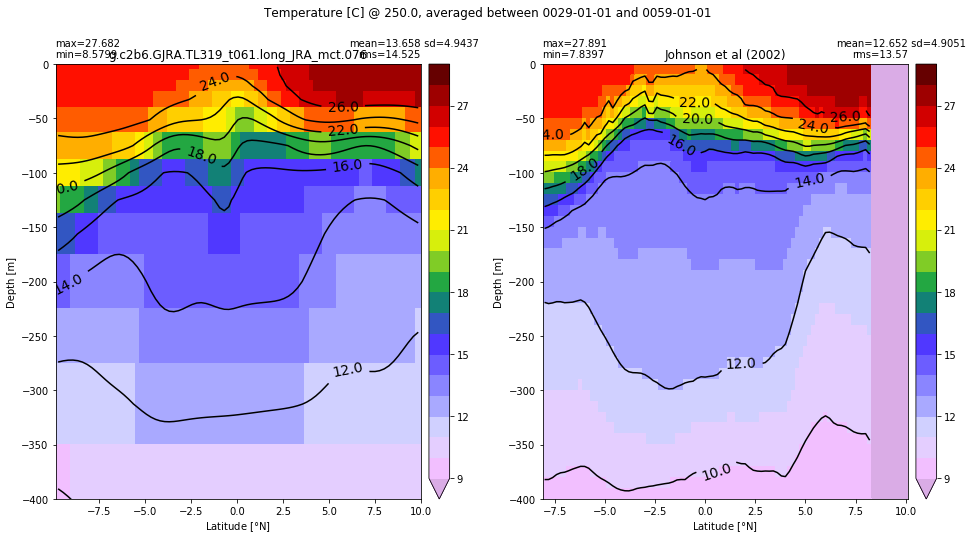

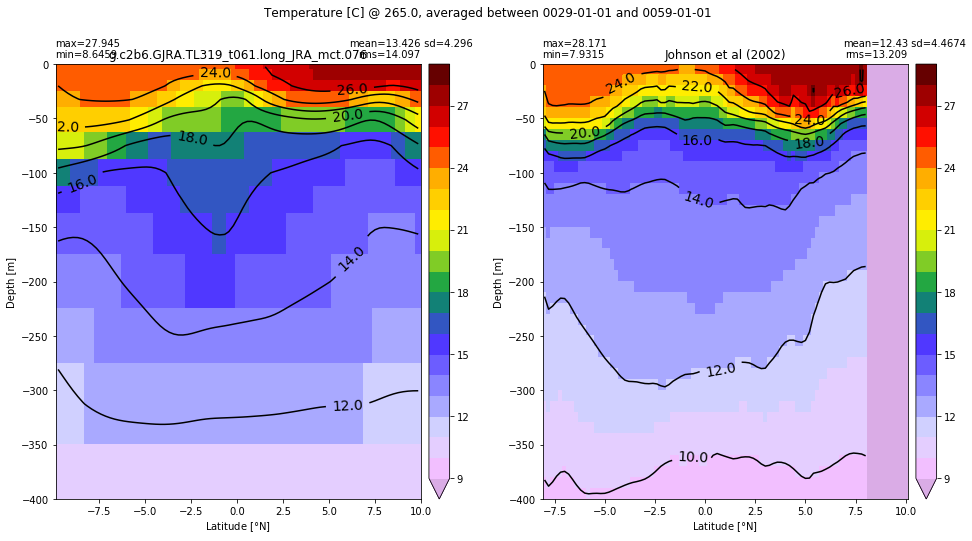

In [24]:
# Temperature
for l in longitudes:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    dummy_model = np.ma.masked_invalid(thetao.sel(xh=l, method='nearest').values)
    dummy_obs = np.ma.masked_invalid(johnson.POTEMPM.sel(XLON=l, method='nearest').values)
    yzplot(dummy_model, y_model, -Z_model, clim=(9,29), axis=ax1, zlabel='Depth', ylabel='Latitude', title=str(dcase.casename))
    cs1 = ax1.contour( y_model + 0*z_model, -z_model, dummy_model, levels=np.arange(0,30,2), colors='k',); plt.clabel(cs1,fmt='%3.1f', fontsize=14)
    ax1.set_ylim(-400,0)
    yzplot(dummy_obs, y_obs, -Z_obs, clim=(9,29), axis=ax2, zlabel='Depth', ylabel='Latitude', title='Johnson et al (2002)')
    cs2 = ax2.contour( y_obs + 0*z_obs, -z_obs, dummy_obs, levels=np.arange(0,30,2), colors='k',); plt.clabel(cs2,fmt='%3.1f', fontsize=14)
    ax2.set_ylim(-400,0)
    plt.suptitle('Temperature [C] @ '+str(l)+ ', averaged between '+str(start_date)+' and '+str(end_date))

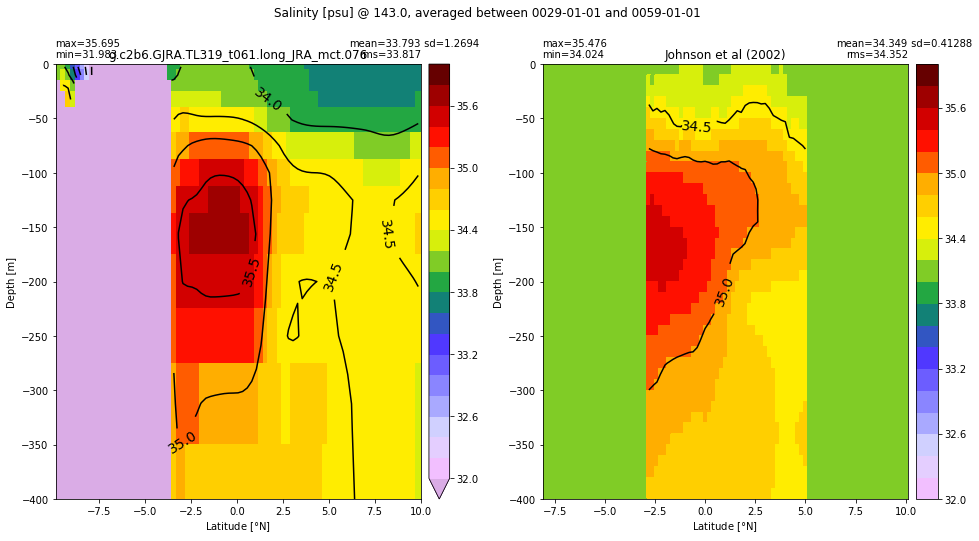

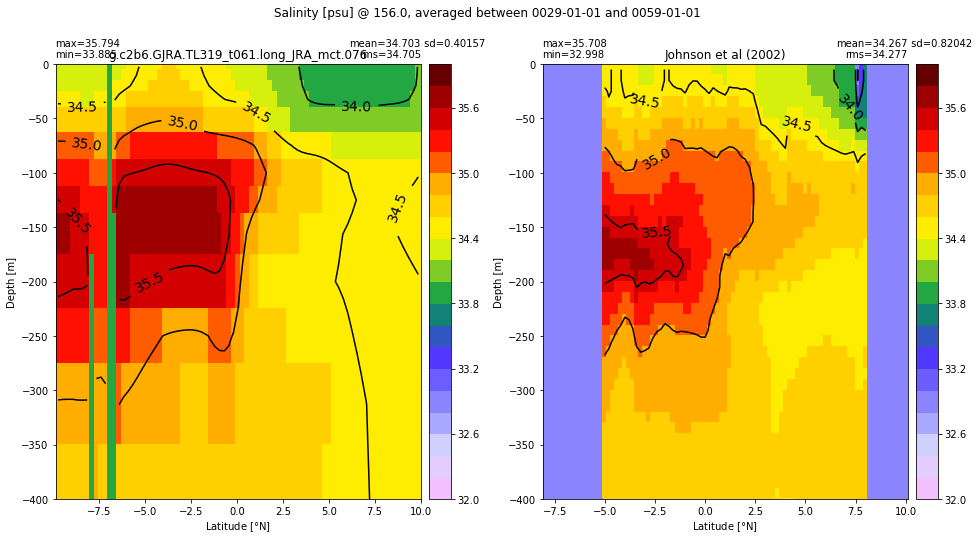

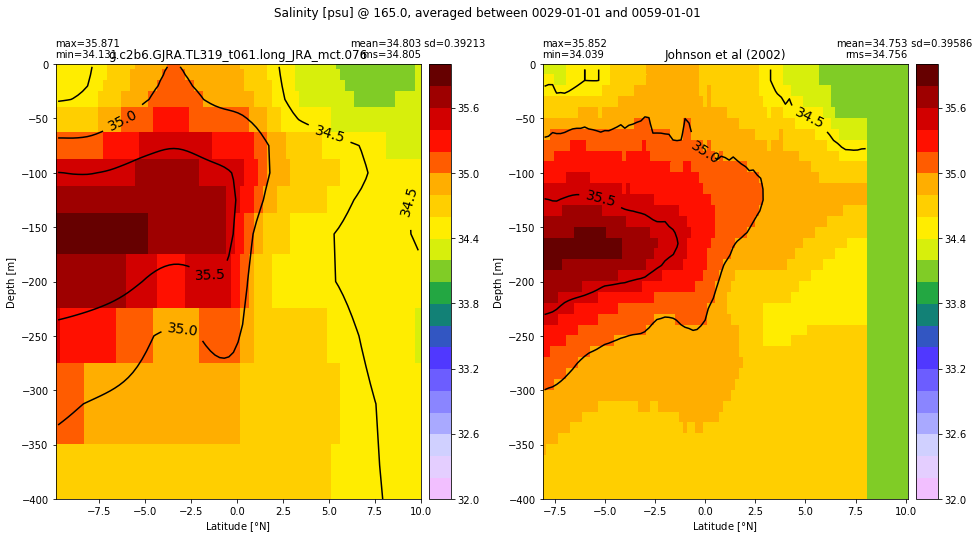

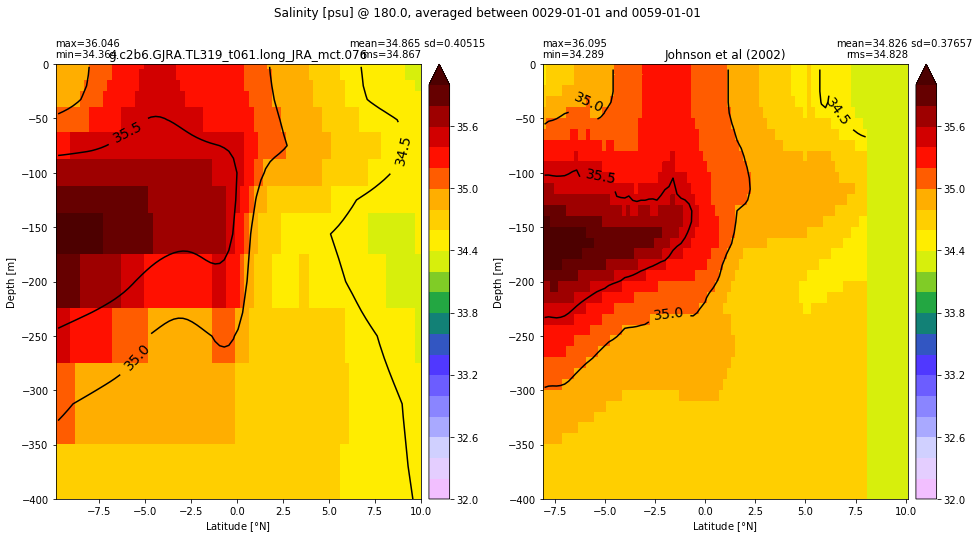

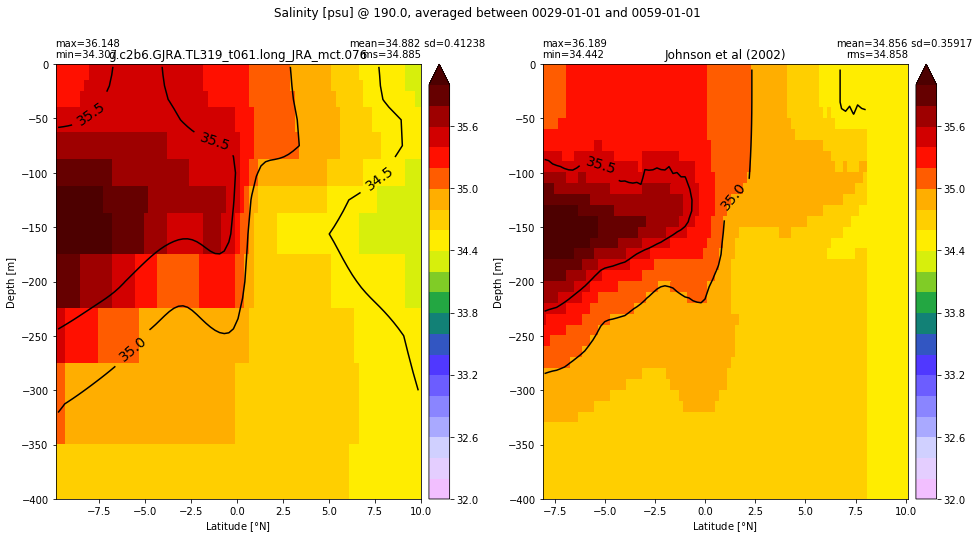

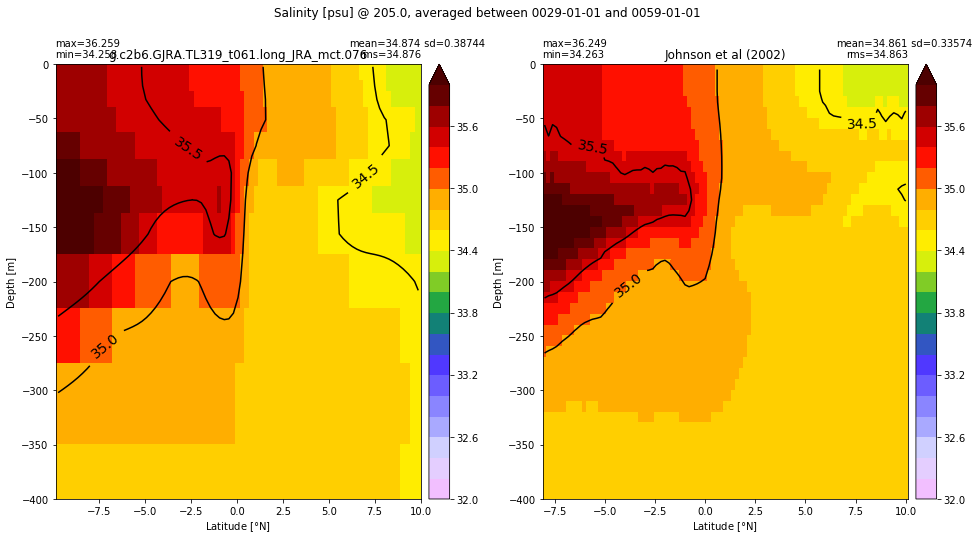

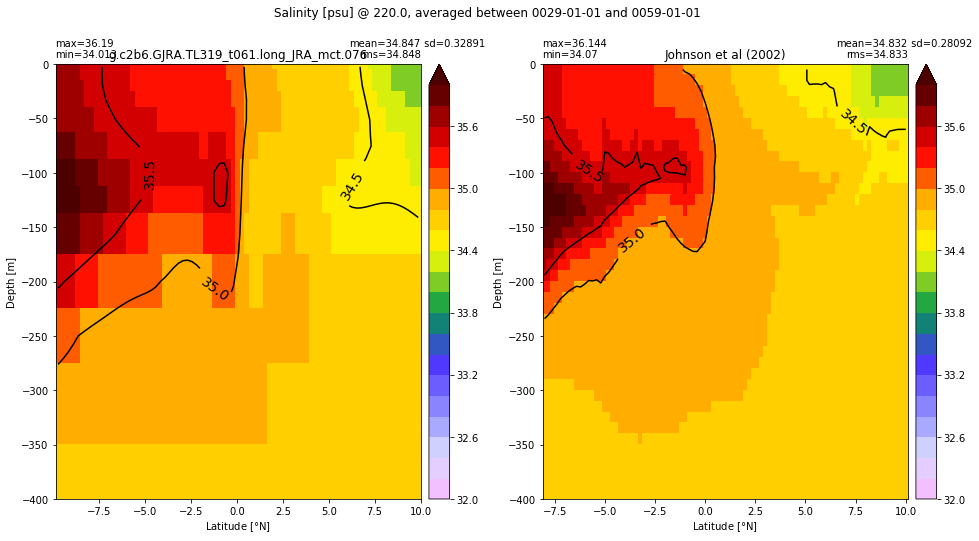

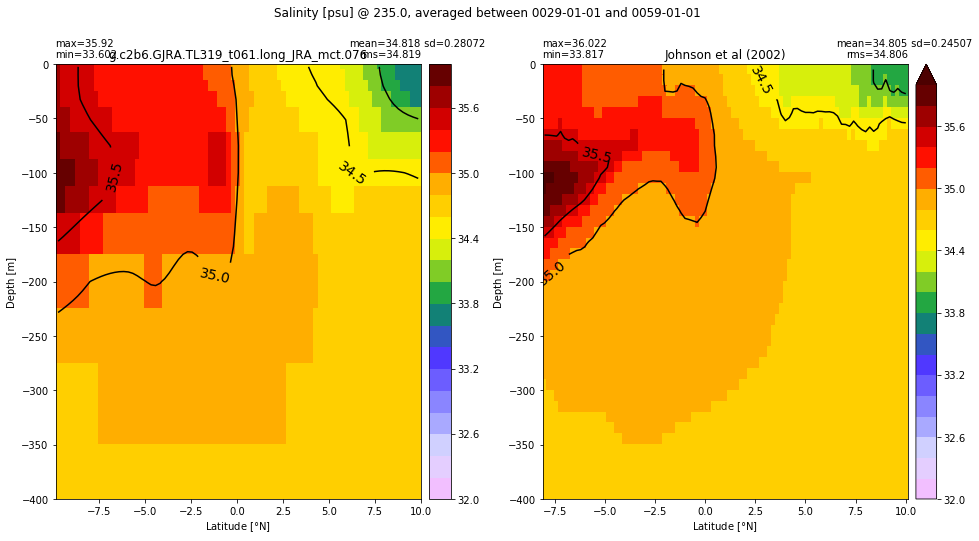

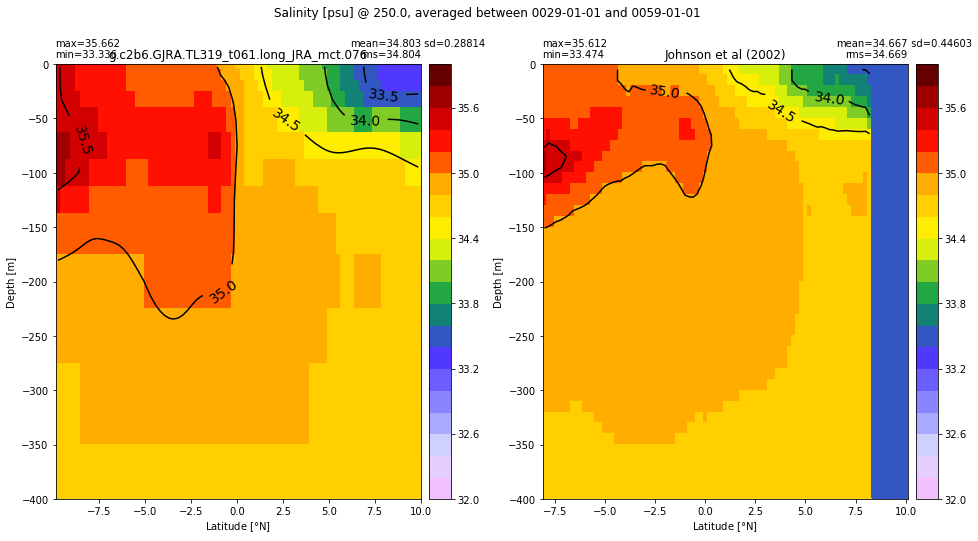

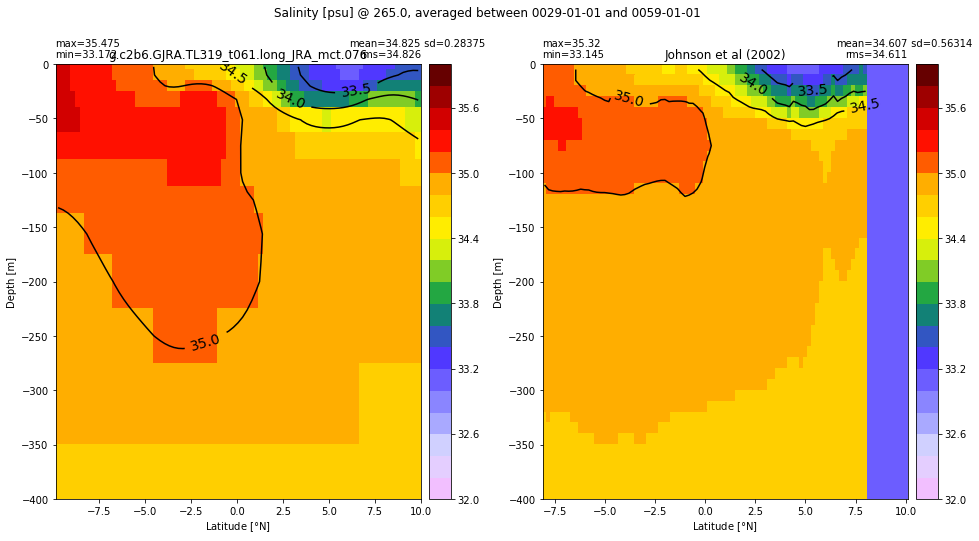

In [25]:
for l in longitudes:
    # Salt
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    dummy_model = np.ma.masked_invalid(so.sel(xh=l, method='nearest').values)
    dummy_obs = np.ma.masked_invalid(johnson.SALINITYM.sel(XLON=l, method='nearest').values)
    yzplot(dummy_model, y_model, -Z_model, clim=(32,36), axis=ax1, zlabel='Depth', ylabel='Latitude', title=str(dcase.casename))
    cs1 = ax1.contour( y_model + 0*z_model, -z_model, dummy_model, levels=np.arange(32,36,0.5), colors='k',); plt.clabel(cs1,fmt='%3.1f', fontsize=14)
    ax1.set_ylim(-400,0)
    yzplot(dummy_obs, y_obs, -Z_obs, clim=(32,36), axis=ax2, zlabel='Depth', ylabel='Latitude', title='Johnson et al (2002)')
    cs2 = ax2.contour( y_obs + 0*z_obs, -z_obs, dummy_obs, levels=np.arange(32,36,0.5), colors='k',); plt.clabel(cs2,fmt='%3.1f', fontsize=14)
    ax2.set_ylim(-400,0)
    plt.suptitle('Salinity [psu] @ '+str(l)+ ', averaged between '+str(start_date)+' and '+str(end_date))

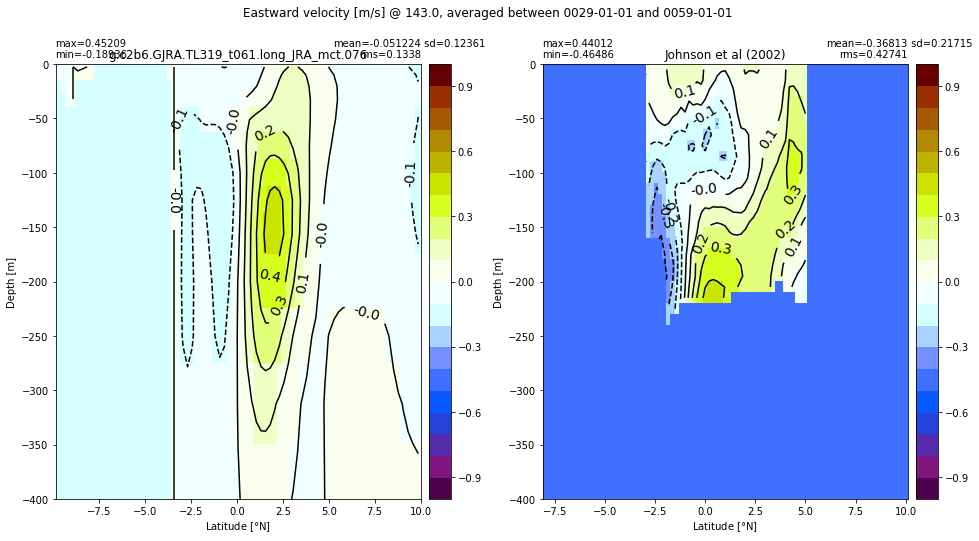

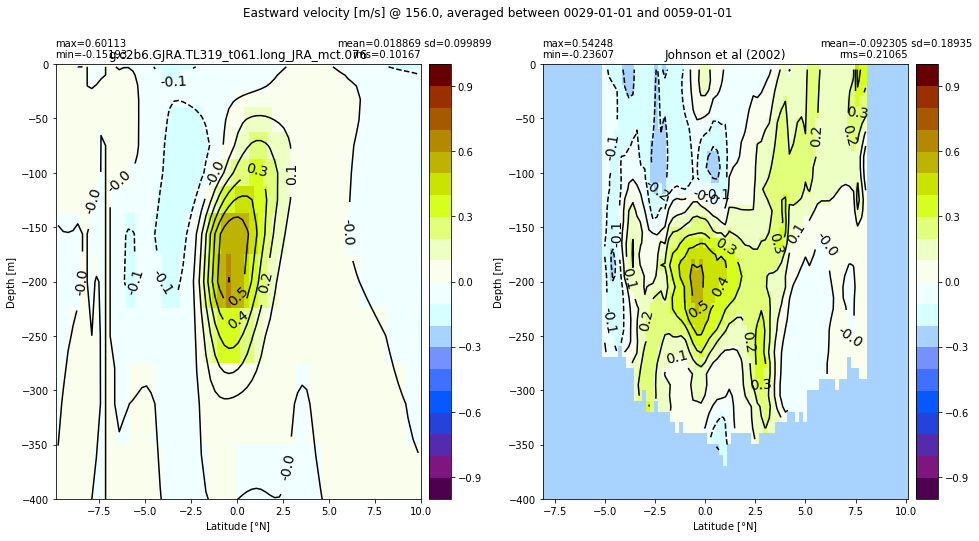

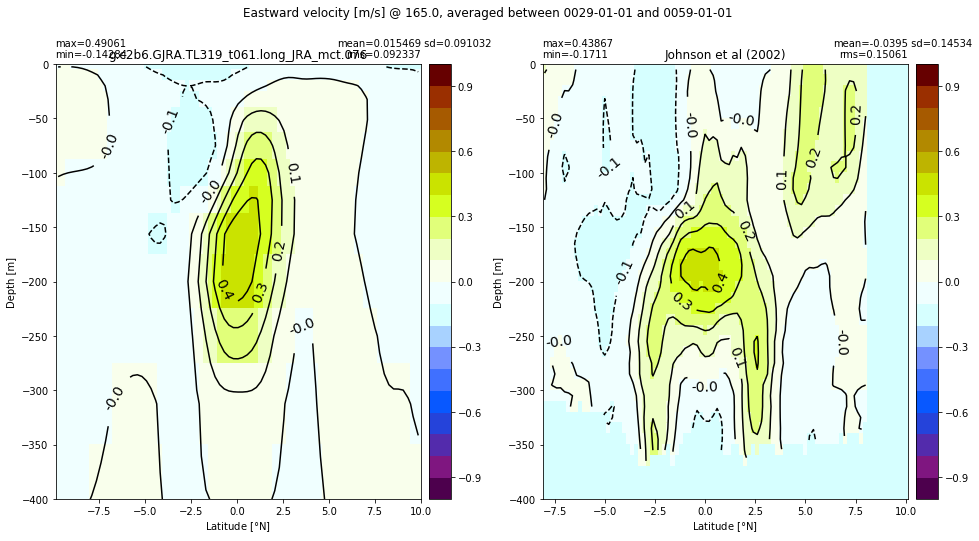

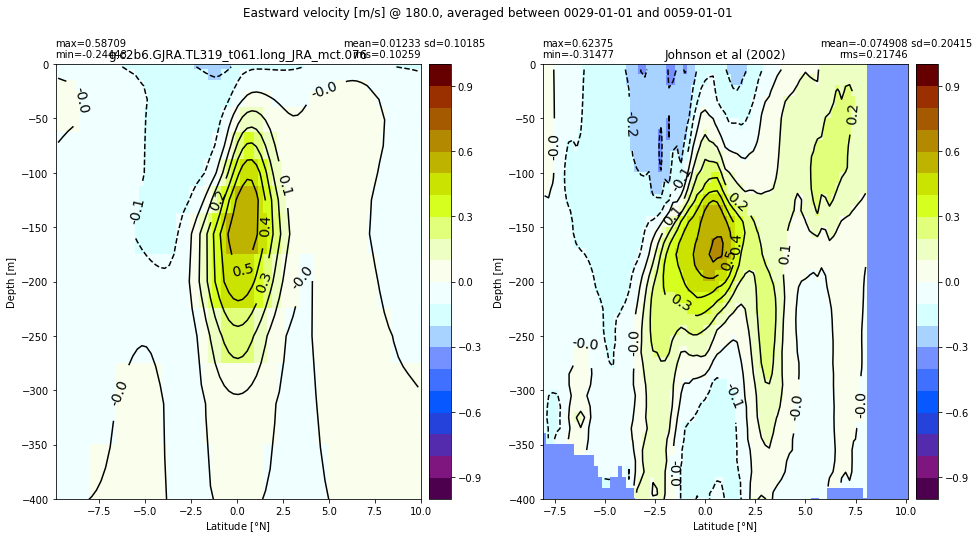

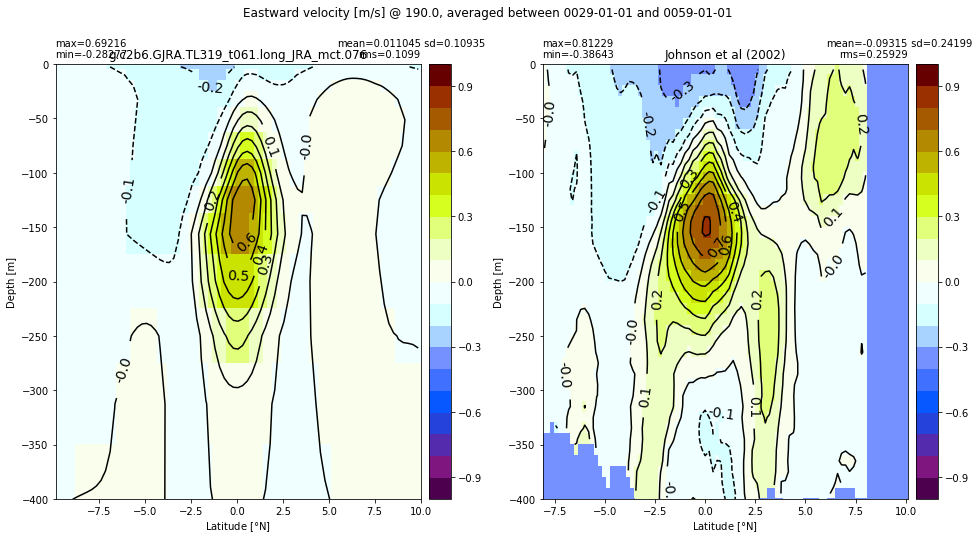

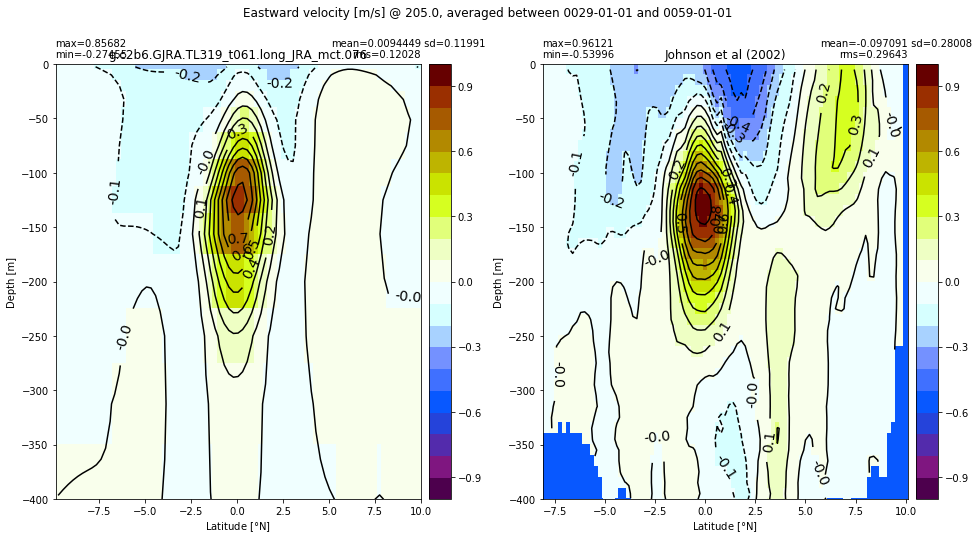

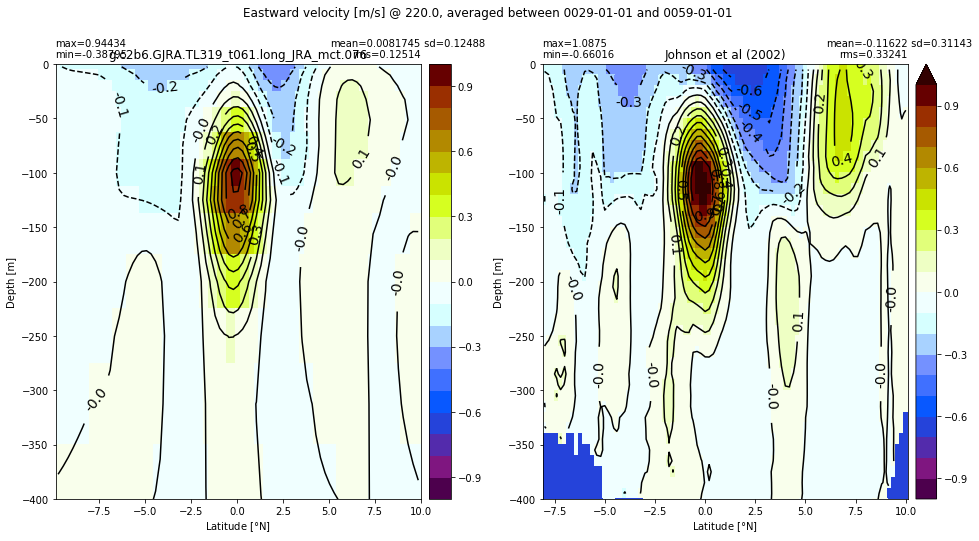

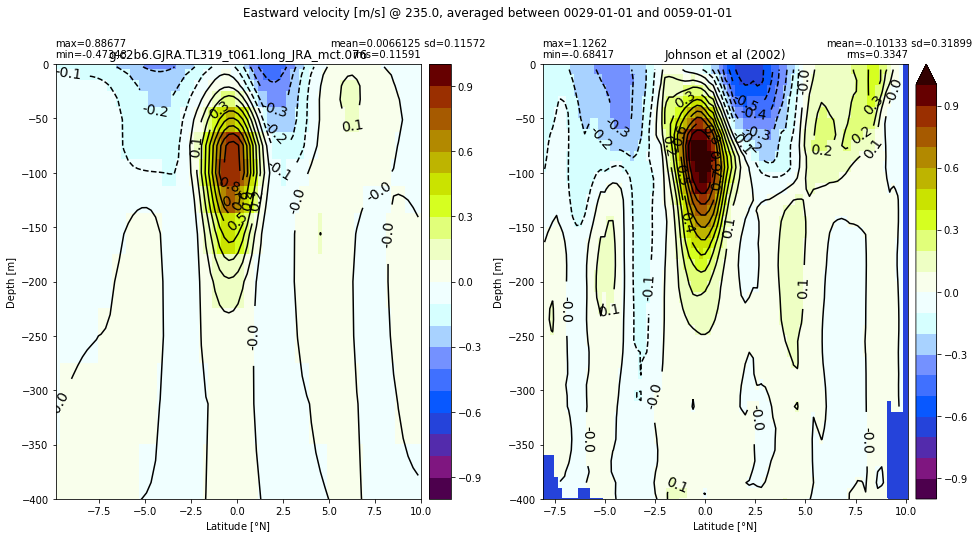

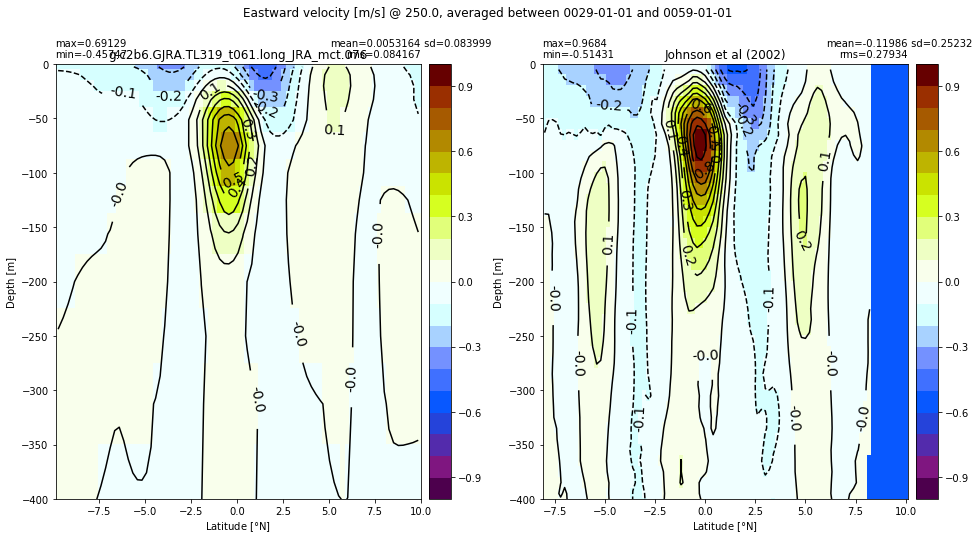

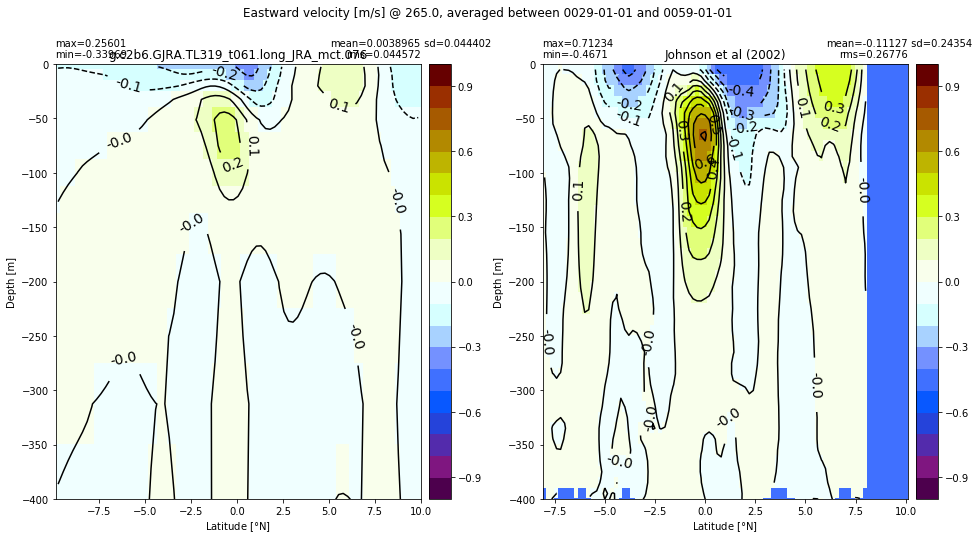

In [26]:
for l in longitudes:
    # uo
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    dummy_model = np.ma.masked_invalid(uo.sel(xq=l, method='nearest').values)
    dummy_obs = np.ma.masked_invalid(johnson.UM.sel(XLON=l, method='nearest').values)
    yzplot(dummy_model, y_model, -Z_model, clim=(-1,1), axis=ax1, zlabel='Depth', ylabel='Latitude', title=str(dcase.casename))
    cs1 = ax1.contour( y_model + 0*z_model, -z_model, dummy_model, levels=np.arange(-1,1,0.1), colors='k',); plt.clabel(cs1,fmt='%3.1f', fontsize=14)
    ax1.set_ylim(-400,0)
    yzplot(dummy_obs, y_obs, -Z_obs, clim=(-1,1), axis=ax2, zlabel='Depth', ylabel='Latitude', title='Johnson et al (2002)')
    cs2 = ax2.contour( y_obs + 0*z_obs, -z_obs, dummy_obs, levels=np.arange(-1,1,0.1), colors='k',); plt.clabel(cs2,fmt='%3.1f', fontsize=14)
    ax2.set_ylim(-400,0)
    plt.suptitle('Eastward velocity [m/s] @ '+str(l)+ ', averaged between '+str(start_date)+' and '+str(end_date))

In [27]:
x_obs = johnson.XLON.values
[X_obs, Z_obs] = np.meshgrid(x_obs, zz)
z_obs = 0.5 * ( Z_obs[:-1,:] + Z_obs[1:,:] )

In [28]:
x_model = so.xh.values
z = eta.z_i.values
[X, Z_model] = np.meshgrid(x_model, z)
z_model = 0.5 * ( Z_model[:-1,:] + Z_model[1:,:] )

Text(0.5, 0.98, 'Eastward velocity [m/s] along the Equatorial Pacific, averaged between 0029-01-01 and 0059-01-01')

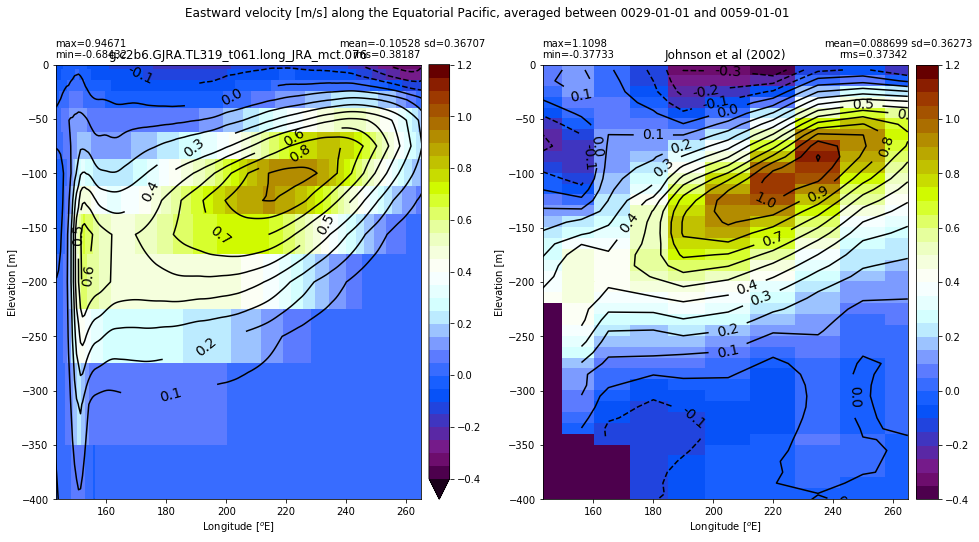

In [32]:
#from mom6_tools.m6plot import 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
dummy_obs = np.ma.masked_invalid(johnson.UM.sel(YLAT11_101=0).values)
dummy_model = np.ma.masked_invalid(uo.sel(yh=0, method='nearest').values)

yzplot(dummy_model, x_model, -Z_model, clim=(-0.4,1.2), axis=ax1, landcolor=[0., 0., 0.], title=str(dcase.casename), ylabel='Longitude', yunits=r'$^o$E' )
cs1 = ax1.contour( x_model + 0*z_model, -z_model, dummy_model,  levels=np.arange(-1.2,1.2,0.1), colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
ax1.set_xlim(143,265); ax1.set_ylim(-400,0)
yzplot(dummy_obs, x_obs, -Z_obs, clim=(-0.4,1.2), axis=ax2, title='Johnson et al (2002)', ylabel='Longitude', yunits=r'$^o$E' )
cs1 = ax2.contour( x_obs + 0*z_obs, -z_obs, dummy_obs,  levels=np.arange(-1.2,1.2,0.1), colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
ax2.set_xlim(143,265); ax2.set_ylim(-400,0)
plt.suptitle('Eastward velocity [m/s] along the Equatorial Pacific, averaged between '+str(start_date)+' and '+str(end_date))